In [21]:
import numpy as np

dataset1_origin = np.load('npz/dataset1_origin.npz', allow_pickle=True)
dataset1_horizon = np.load('npz/dataset1_horizon.npz', allow_pickle=True)
dataset1_vertical = np.load('npz/dataset1_vertical.npz', allow_pickle=True)
dataset1_vh = np.load('npz/dataset1_vh.npz', allow_pickle=True)
dataset2_origin = np.load('npz/dataset2_origin.npz', allow_pickle=True)
dataset2_horizon = np.load('npz/dataset2_horizon.npz', allow_pickle=True)
dataset2_vertical = np.load('npz/dataset2_vertical.npz', allow_pickle=True)
dataset2_vh = np.load('npz/dataset2_vh.npz', allow_pickle=True)

d1o_origin_images, d1o_target_images, d1o_number_labels, d1o_coordinates = dataset1_origin['images'], dataset1_origin['filters'], dataset1_origin['numbers'],  dataset1_origin['coordinates']
d1h_origin_images, d1h_target_images, d1h_number_labels, d1h_coordinates = dataset1_horizon['images'], dataset1_horizon['filters'], dataset1_horizon['numbers'],  dataset1_horizon['coordinates']
d1v_origin_images, d1v_target_images, d1v_number_labels, d1v_coordinates = dataset1_vertical['images'], dataset1_vertical['filters'], dataset1_vertical['numbers'],  dataset1_vertical['coordinates']
d1vh_origin_images, d1vh_target_images, d1vh_number_labels, d1vh_coordinates = dataset1_vh['images'], dataset1_vh['filters'], dataset1_vh['numbers'],  dataset1_vh['coordinates']
d2o_origin_images, d2o_target_images, d2o_number_labels, d2o_coordinates = dataset2_origin['images'], dataset2_origin['filters'], dataset2_origin['numbers'],  dataset2_origin['coordinates']
d2h_origin_images, d2h_target_images, d2h_number_labels, d2h_coordinates = dataset2_horizon['images'], dataset2_horizon['filters'], dataset2_horizon['numbers'],  dataset2_horizon['coordinates']
d2v_origin_images, d2v_target_images, d2v_number_labels, d2v_coordinates = dataset2_vertical['images'], dataset2_vertical['filters'], dataset2_vertical['numbers'],  dataset2_vertical['coordinates']
d2vh_origin_images, d2vh_target_images, d2vh_number_labels, d2vh_coordinates = dataset2_vh['images'], dataset2_vh['filters'], dataset2_vh['numbers'],  dataset2_vh['coordinates']

origin_images = np.concatenate([d1o_origin_images, d2o_origin_images, d1h_origin_images, d2h_origin_images, d1v_origin_images, d2v_origin_images, d1vh_origin_images, d2vh_origin_images], axis = 0)
target_images = np.concatenate([d1o_target_images, d2o_target_images, d1h_target_images, d2h_target_images, d1v_target_images, d2v_target_images, d1vh_target_images, d2vh_target_images], axis = 0)
numbers_labels = np.concatenate([d1o_number_labels, d2o_number_labels, d1h_number_labels, d2h_number_labels, d1v_number_labels, d2v_number_labels, d1vh_number_labels, d2vh_number_labels], axis = 0)
coordinates = np.concatenate([d1o_coordinates, d2o_coordinates, d1h_coordinates, d2h_coordinates, d1v_coordinates, d2v_coordinates, d1vh_coordinates, d2vh_coordinates], axis = 0)


In [22]:
# Filtering out the entries where numbers_labels is 1
one_indices = np.where(numbers_labels == 1)[0]

# Extracting corresponding entries for images and labels
one_origin_images = origin_images[one_indices]
one_number_labels = numbers_labels[one_indices]
one_coordinates = coordinates[one_indices][:, 0, :]
# Saving the filtered data into a .npz file
np.savez('npz/localization.npz', images=one_origin_images, numbers=one_number_labels, coordinates = one_coordinates)

# Verifying the shapes of the saved arrays
one_origin_images.shape, one_number_labels.shape, one_coordinates.shape


((2588, 24, 32), (2588,), (2588, 8))

In [24]:
datasets = np.load('npz/localization.npz', allow_pickle=True)
images, numbers, coordinates = datasets['images'], datasets['numbers'], datasets['coordinates']

print(images.shape, numbers.shape, coordinates.shape)

print(coordinates[2500])

(2588, 24, 32) (2588,) (2588, 8)
[20 22  8 22  8 10 20 10]


In [30]:
import matplotlib.pyplot as plt
def draw_bounding_box_from_vertices(image, vertices):
    """
    Draw a bounding box on an image using a set of 8 coordinates representing four vertices.
    
    :param image: The image on which to draw the bounding box.
    :param vertices: A list or array of 8 coordinates representing the four vertices of the box 
                     in the order (x1, y1, x2, y2, x3, y3, x4, y4).
    :return: Image with the bounding box drawn.
    """
    # Extract x and y coordinates
    x_coords = vertices[0::2]
    y_coords = vertices[1::2]

    # Calculate min and max coordinates
    minx, maxx = min(x_coords), max(x_coords)
    miny, maxy = min(y_coords), max(y_coords)

    # Create a figure and axis to display the image
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Create a Rectangle patch
    rect = patches.Rectangle((minx, miny), maxx - minx, maxy - miny, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()

# Example usage
# draw_bounding_box_from_vertices(some_image, [20, 22, 8, 22, 8, 10, 20, 10])



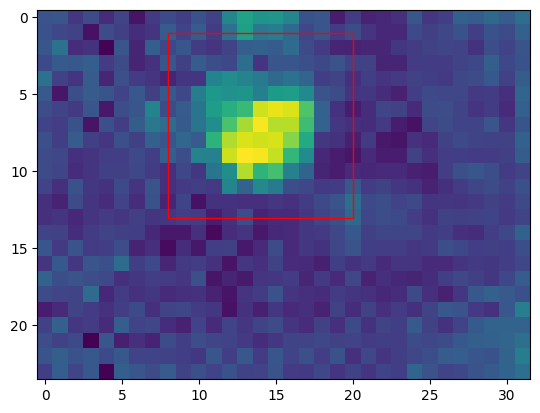

In [38]:
draw_bounding_box_from_vertices(images[700], coordinates[700])